In [1]:
import torch
import tiktoken
from torch.nn import functional as F

In [2]:
computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

torch.set_float32_matmul_precision("high")

Using Compute Device: mps


In [3]:
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))
trainText = text[:1000]
tokens = enc.encode(trainText)

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1], device=computeDevice)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

print(x.shape)
print(y.shape) 

1115394
torch.Size([4, 32])
torch.Size([4, 32])


In [4]:
from train_gpt2 import GPT, GPTConfig
import sys

model = GPT(GPTConfig(vocab_size=50304))
model.to(computeDevice)

if sys.version_info.major == 3 and sys.version_info.minor < 12:
    model = torch.compile(model)
else:
    print(sys.version_info)
    print(f"Cannot compile pytorch model, skipping .....")

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
Cannot compile pytorch model, skipping .....


In [5]:
with torch.no_grad():
    logits, loss = model(x,y)
    print(logits.shape)
    print(loss)

torch.Size([4, 32, 50304])
tensor(10.8994, device='mps:0')


In [6]:
import math

# Cosine learning rate with warm up
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50

def get_lr(it):
    # 1 - Linear warmip for warmip_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps

    # 2 - If it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr

    # 3 - In between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [7]:
from data_loader import DataLoaderLite
import time

torch.mps.empty_cache()
torch.manual_seed(1337)

# B, T = 16, 1024
B, T = 4, 1024

dataset = DataLoaderLite(B, T)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=computeDevice)

losses = []
learn_rates = []
for step in range(max_steps):
    t0 = time.time()
    x, y = dataset.next_batch()
    x, y = x.to(computeDevice), y.to(computeDevice)

    optimizer.zero_grad()
    if torch.cuda.is_available():
        with torch.autocast(device_type=computeDevice, dtype=torch.bfloat16):
            logits, loss = model(x, y)
    else:
        logits, loss = model(x, y)
    loss.backward()

    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)
    learn_rates.append(lr)
    for param_group in optimizer.param_groups:
        param_group[lr] = lr
    optimizer.step()

    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = dataset.B * dataset.T
    tokens_per_sec = tokens_processed / dt

    print(f"Step {step:4d} | loss: {loss.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
    losses.append(loss.item())


Loaded 338025 tokens
1 epoch = 82 batches
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
Using fused AdamW: False, inspect check: True


/Users/aj/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step    0 | loss: 10.940382 | lr: 6.0000e-05 | norm: 28.4366 | dt: 2960.50ms | tok/sec: 1383.55
Step    1 | loss: 9.536893 | lr: 1.2000e-04 | norm: 5.2991 | dt: 3063.49ms | tok/sec: 1337.04
Step    2 | loss: 8.801343 | lr: 1.8000e-04 | norm: 2.6922 | dt: 2782.47ms | tok/sec: 1472.07
Step    3 | loss: 8.576792 | lr: 2.4000e-04 | norm: 8.4336 | dt: 2783.09ms | tok/sec: 1471.75
Step    4 | loss: 7.930079 | lr: 3.0000e-04 | norm: 2.5684 | dt: 2745.98ms | tok/sec: 1491.64
Step    5 | loss: 7.418293 | lr: 3.6000e-04 | norm: 2.9265 | dt: 2801.72ms | tok/sec: 1461.96
Step    6 | loss: 7.138327 | lr: 4.2000e-04 | norm: 1.5244 | dt: 2769.36ms | tok/sec: 1479.04
Step    7 | loss: 6.841079 | lr: 4.8000e-04 | norm: 1.9248 | dt: 2758.87ms | tok/sec: 1484.67
Step    8 | loss: 6.724671 | lr: 5.4000e-04 | norm: 1.1925 | dt: 2762.25ms | tok/sec: 1482.85
Step    9 | loss: 6.426198 | lr: 6.0000e-04 | norm: 1.2688 | dt: 2790.11ms | tok/sec: 1468.05
Step   10 | loss: 6.523280 | lr: 6.0000e-04 | norm: 1.1403

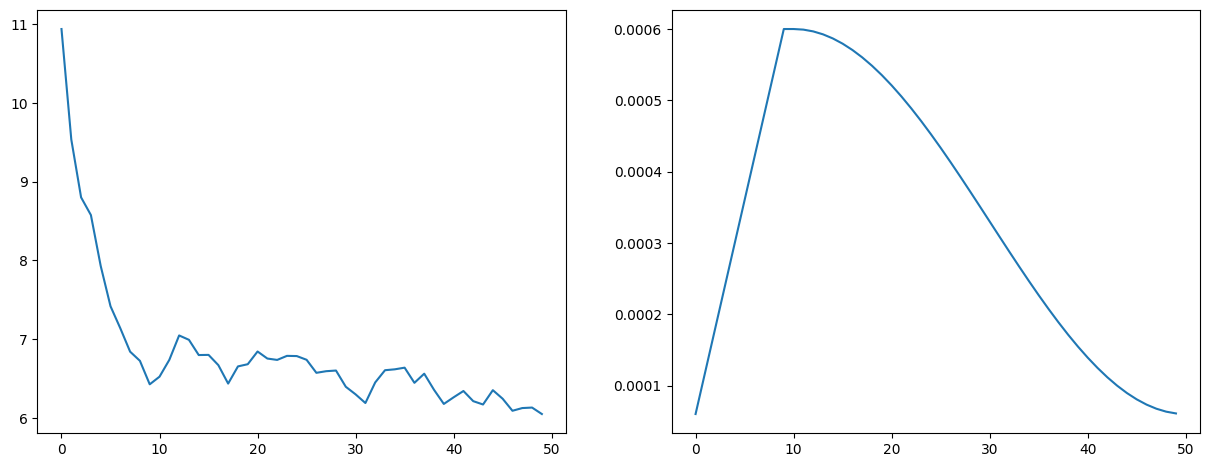

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5.5)

axs[0].plot(losses)
axs[1].plot(learn_rates)

In [9]:
torch.mps.empty_cache() #GPUPoor

evalText = text[1000:]
evalData = enc.encode(evalText)
B, maxT = 8, 512

x = torch.tensor(evalData[:B * maxT], device=computeDevice)
x = x.view(B, maxT)

# evalText = "Second Citizen:\nWould you proceed especially against Caius Marcius?"
# evalData = enc.encode(evalText)
# x = torch.tensor(evalData, device=computeDevice)
# x = x.view(1, -1)

with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:,-1,:]
    probs = F.softmax(logits, dim=-1)
    # do top-k sampling of 50
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    ix = torch.multinomial(topk_probs, 1) # (B,1)
    xcol = torch.gather(topk_indices, -1, ix)
    x = torch.cat((x, xcol), dim=1)

In [10]:
print(enc.decode(x[0,:-1].tolist()))
print("***" * 10)
for i in range(x.size(0)):
    print("--")
    print(enc.decode([x[i,-1].tolist()]))

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to say it was for his country he did it to
please his mother and to be partly proud; which he
is, even till the altitude of his virtue.

Second Citizen:
What he cannot help in his nature, you account a
vice in him. You must in no way say he is covetous.

First Citizen:
If I must not, I need not be barren of accusations;
he hath faults, with surplus, to tire in repetition.
What shouts are these? The other side o' the city
is risen: why stay we prating here? to the Capitol!

All:
Come, come.

First C